# Example for Ignition

The following is a streamlined approach using YAML input to specify simulated conditions.

In [1]:
import numpy as np
import cantera as ct
import pandas as pd
import yaml
import multiprocessing as mp

In [2]:
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


## 1. Function/Class Definitions



In [3]:
import zerod as zd
import zerod.tools as zdt
zd.__version__

'0.2.0'

## 2. Simulations

### 2.1 Parameters are specified via YAML file

In [4]:
fname = 'ignition.yaml'

In [5]:
# output contents of yml file
with open(fname,'r') as yml:
    print(yml.read())

# example YAML file
# specifies parameter variation for fuel
variation:
  entry: [initial, fuel] 
  values: ['CH4','C2H4','C3H8','CH3OCH3','C2H5OH']
output:
  format: h5
  save_species: ['OH','CO'] # <-- True/False or tuple of species
configuration:
  initial:
    T_initial: [1000., kelvin]
    pressure: [101325.0, pascal]
    phi: [1., dimensionless, 'equivalence ratio']
    fuel: 'C3H8'
    diluent: 'N2'
    o2_percent: [21., dimensionless]
  chemistry:
    mechanism: AramcoMech1.3.xml
    path: ../mech
  simulation:
    delta_t: 1.e-4
    delta_Tmax: 25.
    n_points: 5000
    atol: 1.e-15
    rtol: 1.e-9
    max_time_step: 5.e-6
version: 0.2.0 # minimum version of zerod code



In [6]:
# create variation object
nv = zd.Variation.from_yaml(fname, verbosity=1)
nv

Simulated values: ['CH4', 'C2H4', 'C3H8', 'CH3OCH3', 'C2H5OH']


### 2.2 Set up ZeroD Object

In [7]:
%%time
nv.run_serial(reactor=zd.Ignition)

 * processing `initial.fuel`: CH4
 * processing `initial.fuel`: C2H4
 * processing `initial.fuel`: C3H8
 * processing `initial.fuel`: CH3OCH3
 * processing `initial.fuel`: C2H5OH
CPU times: user 2min 36s, sys: 8.56 s, total: 2min 44s
Wall time: 2min 45s


True

In [8]:
%%time
nv.run_parallel(reactor=zd.Ignition,number_of_processes=5)

 * processing `initial.fuel`: CH4 (Process-1)
 * processing `initial.fuel`: C2H4 (Process-2)
 * processing `initial.fuel`: C3H8 (Process-3)
 * processing `initial.fuel`: CH3OCH3 (Process-4)
 * processing `initial.fuel`: C2H5OH (Process-5)
CPU times: user 11.4 ms, sys: 30.5 ms, total: 42 ms
Wall time: 1min 4s


True

## 3. Create graphical output

In [9]:
# load data from output file
data, cfg, var = zdt.from_hdf(nv.oname)
data.keys()

dict_keys(['CH3OCH3', 'C3H8', 'C2H4', 'CH4', 'C2H5OH'])

In [10]:
import matplotlib.pyplot as plt
import matplotlib as mpl

col = mpl.rcParams['axes.prop_cycle'].by_key()['color']

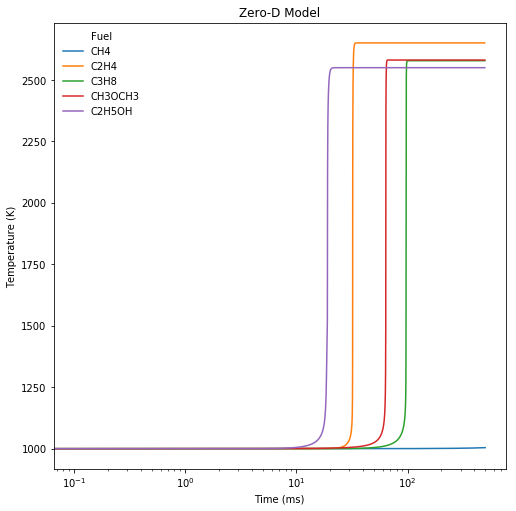

In [11]:
# create figure and adjust size/spacing
fig, ax = plt.subplots(1) #
fig.set_size_inches(8.,8.,forward=True)
fig.subplots_adjust(hspace=0,bottom=.125,top=.9,left=.17,right=.955)

# plot results
for f, fuel in enumerate(nv):
    df = data[fuel]
    ax.semilogx(1000*df['t (s)'],df['T (K)'],color=col[f],label=fuel) 

# add title/axis labels
ax.set_title(r'Zero-D Model')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Temperature (K)')
#ax.set_xlim([wall.xup,wall.xdn])

# add legend
#mech = reactor.chemistry['mechanism']
leg = ax.legend(loc='upper left',#prop={'size':11},
                title='Fuel') # % mech)
leg.draw_frame(False) 

# show and save
plt.show()